# Gmail data analysis
### Exploring more than 5 years of Gmail messages

I learned recently that Google allows its users to download metadata for all the messages sent and received through Gmail. This leads to interesting insights to be found in the data: *What are the most common people I have been in touch with? What days of the week or time of the day have the highest trafic?* In order to explore these and other questions I decided to request my data and perform the present analysis.

The first step is [requesting the data](https://takeout.google.com/settings/takeout). There is data available for several Google services, only the Gmail data is used here. Depending on the amount of data the request can take several hours (my file is 3.03GB). Once we are notified that the file is ready to be downloaded, the data will come in a special format called `mailbox`. After importing some useful modules we can clean and explore the data.

## Requirements

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import mailbox
import pandas as pd
import csv
import unicodedata
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(rc={'figure.facecolor':'white'})

# For better quality plots use
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')

from time import time
from collections import Counter

<ipython-input-2-036d9073cc2f>:12: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('pdf', 'svg')


## Data preprocessing
One of the most important steps before analyzing the data is its proper cleaning, which refers to removing unnecessary data, dealing with missing values, grouping fields that appear different for the machine but that refer to the same items, etc.
We begin by saving the data file `gmail_data.mbox` in a directory called `data` (for privacy reasons, this file is absent from the GitHub repository). The file can be loaded using the `mailbox` module

In [6]:
file_path ='/content/drive/MyDrive/Classroom/All mail Including Spam and Trash-001.mbox'
mbox = mailbox.mbox(file_path)
print('samples:', len(mbox))

samples: 0


The file contains 2748 samples. Even though these are mostly email messages, many other entry types are counted, such as drafts and chats. These can be removed by filtering by Gmail label. The file contains the following fields

In [8]:
# print fields
for i, key in enumerate(mbox[1].keys()):
    print(i+1, key)

KeyError: 'No message with key: 1'

We find that there are several section of little interest. In order to avoid loading unnecessary information, we can extract the fields of interest and put them into a `pandas` dataframe for further processing. We are interested in the following fields: `subject`, `from`, `to`, `date`, and `Gmail-label`.

In [ ]:
t0 = time()
subject = []
from_ = []
to = []
date = []
label = []
for i, message in enumerate(mbox):
    try:
        if i%2000 == 0:
            print(i, end=' ')
        subject.append(message['subject'])
        from_.append(message['from'])
        to.append(message['to'])
        date.append(message['date'])
        label.append(message['X-Gmail-Labels'])
    except:
        print(i, end=' ')
        print('subject', subject[i])
        print('from', from_[i])
        print('to', to[i])
        print('date', date[i])
        print('label', label[i])
print('\ntime: {:.1f} min'.format((time()-t0)/60))

0 2000 
time: 1.9 min



This code appears to be a Python script designed to process email messages stored in a mailbox (mbox) format. Let's break down what each part of the code does:

t0 = time(): This line records the starting time of the script's execution. The time module needs to be imported for this to work (import time).

subject = [], from_ = [], to = [], date = [], label = []: These lines initialize empty lists to store information extracted from each email message. Each list corresponds to different attributes of the email messages, such as subject, sender, recipient, date, and labels.

for i, message in enumerate(mbox):: This line initiates a loop that iterates through each message in the mbox object. The enumerate() function provides both the index (i) and the corresponding message (message) for each iteration.

try:: This line starts a try-except block, indicating that the code inside the block will be attempted, and if any errors occur, they will be caught by the except block.

if i%2000 == 0:: This line checks if the index i is divisible by 2000 with no remainder. This condition is met every 2000 messages, and when true, it prints the current index (to track progress) without moving to a new line.

subject.append(message['subject']), from_.append(message['from']), to.append(message['to']), date.append(message['date']), label.append(message['X-Gmail-Labels']): These lines extract specific fields from the current email message (message) and append them to their respective lists. The fields being extracted include the subject, sender, recipient, date, and labels.

except:: This block catches any exceptions that occur within the try block. If an exception occurs, it prints out the index i, along with the values of the subject, sender, recipient, date, and labels associated with that message.

print('\ntime: {:.1f} min'.format((time()-t0)/60)): This line calculates the total execution time of the script by subtracting the starting time (t0) from the current time and then dividing by 60 to convert the result to minutes. It then prints out the total time taken for execution.

In [ ]:
df = pd.DataFrame()
df['subject'] = subject
df['from'] = from_
df['to'] = to
df['date'] = date
df['label'] = label

In [ ]:
df[['subject', 'date', 'label']].head()

,subject,date,label
0,"Krishnan, you are pre-approved for HDFC Bank C...","Wed, 13 Mar 2024 20:02:00 +0530","Inbox,Category promotions,Unread"
1,"=?UTF-8?q?Krishnan,_Credit_Limit_up_to_Rs_1000...","Mon, 11 Mar 2024 08:34:41 +0000","Inbox,Category updates,Unread"
2,GenAI's Revolutionary Projects for 2024,"Sun, 17 Mar 2024 04:31:07 +0000","Inbox,Category updates,Unread"
3,=?utf-8?q?Can_you_tell_me_something_about_your...,"Fri, 15 Mar 2024 03:25:28 +0000","Inbox,Category social,Unread"
4,"=?UTF-8?q?Krishnan,_You've_earned_a_Lifetime_F...","Wed, 6 Mar 2024 12:29:43 +0000","Inbox,Category updates,Unread"


In [ ]:
def remove_accents(text):
    text = str(text)
    nfkd_norm = unicodedata.normalize('NFKD', text)
    text = nfkd_norm.encode('ASCII', 'ignore').decode('utf-8')
    return text

In [ ]:
df['subject'] = df['subject'].map(remove_accents)

After cleaning the `subject` field, we can get a general overview of the integrity of different fields

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2748 entries, 0 to 2747
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   subject  2748 non-null   object
 1   from     2748 non-null   object
 2   to       2677 non-null   object
 3   date     2748 non-null   object
 4   label    2748 non-null   object
dtypes: object(5)
memory usage: 107.5+ KB


We find that `to`, one of the most relevant fields, contains some null entries. Which has to be removed.

In [ ]:
len(df[df['to'].isnull()])

71

In [ ]:
# delete null rows
df = df[df['to'].notnull()]
len(df)

2677

The next goal is to transform the class type: dates are given as strings

In [ ]:
df[['date']].head()

,date
0,"Wed, 13 Mar 2024 20:02:00 +0530"
1,"Mon, 11 Mar 2024 08:34:41 +0000"
2,"Sun, 17 Mar 2024 04:31:07 +0000"
3,"Fri, 15 Mar 2024 03:25:28 +0000"
4,"Wed, 6 Mar 2024 12:29:43 +0000"


These string dates can be converted into timestamps using the converted available for dataframes

In [ ]:
df['date'] = df['date'].apply(lambda x: pd.to_datetime(x, errors='coerce', utc=True))

Some dates have unappropriate shape for conversion (these are drafts of spam messages), which can be simply removed

In [ ]:
df = df[df['date'].notnull()]

Given that the date is now a timestamp, messages can be easily sorted by date, after which the dataframe index must be reset

In [ ]:
df = df.sort_values(['date'], ascending=False)
df = df.reset_index(drop=True)

The most recent messages are the following

In [ ]:
df[['subject', 'date', 'label']].head(8)

,subject,date,label
0,"=?UTF-8?q?Krishnan,_It_can't_get_better_than_t...",2024-03-17 10:17:55+00:00,"Inbox,Opened,Category updates"
1,Re: Article to be added [240308-003954],2024-03-17 09:09:48+00:00,"Inbox,Important,Opened,Category personal"
2,=?utf-8?B?8J+SuCBTdGFydCB3aXRoIHlvdXIgU2F2aW5n...,2024-03-17 04:40:28+00:00,"Inbox,Category updates,Unread"
3,GenAI's Revolutionary Projects for 2024,2024-03-17 04:31:07+00:00,"Inbox,Category updates,Unread"
4,Week 11: SUZLON is down 3.0% this week and the...,2024-03-17 03:48:34+00:00,"Inbox,Category updates,Unread"
5,Keep Calm & UPI On: Essential Security Tips fo...,2024-03-17 03:44:07+00:00,"Inbox,Opened,Category updates"
6,Next-Level Data Validation Toolkit for dbt Dat...,2024-03-17 01:50:00+00:00,"Inbox,Category updates,Unread"
7,=?utf-8?q?What_are_your_SSC_CHSL_2021_normalis...,2024-03-16 18:00:43+00:00,"Inbox,Category updates,Unread"


where the most recent message is the notification from Gmail to download the data used here. The oldest messages are

In [ ]:
df[['subject', 'date', 'label']].tail(9)

,subject,date,label
2667,=?utf-8?q?=C2=A0Scheduled_Maintenance_Activity...,2022-01-11 12:25:00+00:00,"Inbox,Category updates,Unread"
2668,Cheque book alert,2022-01-08 08:47:57+00:00,"Inbox,Opened,Category updates"
2669,Use your debit card for online/International/C...,2022-01-07 07:41:01+00:00,"Inbox,Opened,Category updates"
2670,Email ID Updation,2022-01-07 02:37:41+00:00,"Inbox,Important,Category updates,Unread"
2671,"Krishnan, take the next step on your Windows b...",2022-01-06 10:14:45+00:00,"Inbox,Opened,Category updates"
2672,Security alert,2022-01-06 10:13:41+00:00,"Important,Bin,Category updates"
2673,Contact Details Modification - Verification Token,2022-01-06 10:11:58+00:00,"Inbox,Important,Opened,Category updates"
2674,"Krishnan, take the next step on your Windows b...",2021-12-30 02:46:09+00:00,"Inbox,Opened,Category updates"
2675,"Krishnan, finish setting up your new Google Ac...",2021-12-19 15:42:06+00:00,"Inbox,Opened,Category updates"


Finally, there are many messages in the `Drafts` folder that should also be removed

In [ ]:
df = df[df['label'] != 'Drafts']

The same applies for `Spam` messages. Unfortunately, this label does not appear alone so it must be searched in the `label` column

In [ ]:
cnt = 0
idx_to_remove = []
for i, lab in enumerate(df['label']):
    if 'Spam' in str(lab):
        idx_to_remove.append(i)

df = df.drop(df.index[idx_to_remove])
df = df.reset_index(drop=True)

At this point, and given the time used for cleaning the data file, it is a good idea to export it as a `csv` file for future use without the need of redoing the preprocessing above.

In [ ]:
df.to_csv('/content/drive/MyDrive/gmail_data_preprocessed.csv',
          encoding='utf-8', index=False)

# **Data exploration**

We can now begin exploring the data set.

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/gmail_data_preprocessed.csv')
len(df)

2662

Since the data was loaded from a `csv` file, the dates are back as `str` so they must be converted into `timestamp` again

In [ ]:
df['date'] = df['date'].apply(lambda x: pd.to_datetime(x))

## **1. Incoming vs. outgoing messages**
For simplicity, all messages written by me or sent to me can be labeled by the string `me` instead of my email address. This will make the identification of incoming and outgoing emails easier. For this the following helper function returns `me` my email address is found and leaves the text unchanged, otherwise:

In [ ]:
def rename_me(txt):
    txt = str(txt).lower()
    if('krishariharan2009@gmail.com' in txt or
       '25012001' in txt):
        txt_out = 'me'
    else:
        txt_out = txt
    return txt_out

In [ ]:
df['from'] = df['from'].apply(rename_me)
df['to'] = df['to'].apply(rename_me)

In [ ]:
df[['subject', 'to', 'date', 'label']].head(4)

,subject,to,date,label
0,"=?UTF-8?q?Krishnan,_It_can't_get_better_than_t...",me,2024-03-17 10:17:55+00:00,"Inbox,Opened,Category updates"
1,Re: Article to be added [240308-003954],me,2024-03-17 09:09:48+00:00,"Inbox,Important,Opened,Category personal"
2,=?utf-8?B?8J+SuCBTdGFydCB3aXRoIHlvdXIgU2F2aW5n...,krishnan hariharan,2024-03-17 04:40:28+00:00,"Inbox,Category updates,Unread"
3,GenAI's Revolutionary Projects for 2024,me,2024-03-17 04:31:07+00:00,"Inbox,Category updates,Unread"


Since we want to explore the statistical distribution of messages, a useful information is a count of messages, for which a unit `count` column can be created

In [ ]:
df['count'] = [1 for _ in range(len(df))]

In order to keep the original data intact, we can make a copy and set the timestamp as a index, so that messages can be grouped and resampled by time periods

In [ ]:
data = df.copy()
data.set_index('date', drop=True, inplace=True)

Now we can identify incoming vs. outgoing emails

In [ ]:
data_in = data[data['to'] == 'me']
data_out = data[data['from'] == 'me']

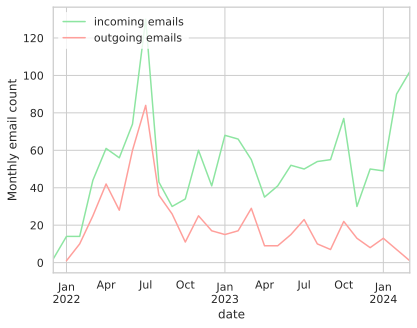

In [ ]:
monthly_in = data_in['count'].resample('M').sum()
monthly_out= data_out['count'].resample('M').sum()
monthly_in.plot(color='g', label='incoming emails')
monthly_out.plot(color='r', label='outgoing emails')
plt.ylabel('Monthly email count')
plt.legend(loc='upper left', frameon=True).get_frame().set_color('white');

It can be seen that most of the time the number of received emails is greater than the number of emails sent.

## **2. Busy days**

We can now try to identify email activity vs. day of the week. We use the `timestamp` method `weekday()`, which returns an index [0....6] corresponding to the days of the from Monday to Sunday.

In [ ]:
dow = []
for i in range(len(df)):
    dow.append(df['date'][i].weekday())

Create new `series` with the day of the week of the message

In [ ]:
df['dow'] = dow
df[['subject', 'date', 'dow', 'label']].head(4)

,subject,date,dow,label
0,"=?UTF-8?q?Krishnan,_It_can't_get_better_than_t...",2024-03-17 10:17:55+00:00,6,"Inbox,Opened,Category updates"
1,Re: Article to be added [240308-003954],2024-03-17 09:09:48+00:00,6,"Inbox,Important,Opened,Category personal"
2,=?utf-8?B?8J+SuCBTdGFydCB3aXRoIHlvdXIgU2F2aW5n...,2024-03-17 04:40:28+00:00,6,"Inbox,Category updates,Unread"
3,GenAI's Revolutionary Projects for 2024,2024-03-17 04:31:07+00:00,6,"Inbox,Category updates,Unread"


In [ ]:
df_in = df[df['to'] == 'me']
df_out = df[df['from'] == 'me']

We can now get the distribution of messages per day of the week. For this a dictionary can easily capture the frequency of messages on each day

In [ ]:
dow_in, dow_out = {}, {}
for i in range(7):
    dow_in[i] = 0
    dow_out[i] = 0
for i in df_in['dow']:
    dow_in[i] += 1
for i in df_out['dow']:
    dow_out[i] += 1

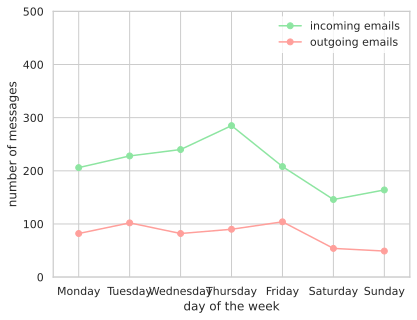

In [ ]:
x, y_in, y_out, y_all = [], [], [], []
for key in dow_in.keys():
    x.append(key)
    y_in.append(dow_in[key])
    y_out.append(dow_out[key])
    y_all.append(dow_in[key] + dow_out[key])

plt.plot(x, y_in, 'o-', color='g', label='incoming emails')
plt.plot(x, y_out, 'o-', color='r', label='outgoing emails')
plt.axis([-0.5, 6.5, 0, 500])
plt.xlabel('day of the week')
plt.ylabel('number of messages')
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
plt.xticks(x, days)
plt.legend(frameon=True).get_frame().set_color('white');

This plot shows clearly that the activity is quite uniform during the week days and it decreases during the weekens, as sort of expected.

## **3. Frequent contacts**
Another immediate question that can be answered with this data is regarding the most frequent contacts I have received messages from and those to whom I have written the most. Just as done earlier with my email address that was replaced by the string `me`.

***For the privacy of my contacts (I prefer not to post their email address) can be protected by creating a function that can replace their contact information with a nickname.***

In [ ]:
def nickname(txt, list_to_rename, new_name):
    txt = str(txt)
    for name in list_to_rename:
        if name in txt.lower():
            txt_out = new_name
            break
        else:
            txt_out = txt
    return txt_out

where `txt` is the text where the names on the list `list_to_rename` are been searched, if found they will be replaced by the nickname `new_name`.This is done for a few frequent contacts.

In [ ]:
df['to'] = df['to'].apply(lambda x: nickname(x, ['vivekanand g <vivekanand.g@alliance.edu.in>'], 'vivek'))
df['to'] = df['to'].apply(lambda x: nickname(x, ['krishariharan2009 <krishariharan2009@gmail.com>'], 'myself'))
df['to'] = df['to'].apply(lambda x: nickname(x, ['"operations, school of business, alliance university"\r\n\t<operations@alliance.edu.in>'], 'alliance'))
df['to'] = df['to'].apply(lambda x: nickname(x, ['krishariharan2009 <krishariharan2009@gmail.com>'], 'myself'))
df['to'] = df['to'].apply(lambda x: nickname(x, ['bhogaan p <bhogaan.p@alliance.edu.in>'], 'Bhogan Alliance University'))
df['to'] = df['to'].apply(lambda x: nickname(x, ['vivekanand <vivekanand.g@alliance.edu.in>'], 'Vivek Anand G'))
df['to'] = df['to'].apply(lambda x: nickname(x, ['<krishariharan2009@gmail.com>'], 'myself'))
df['to'] = df['to'].apply(lambda x: nickname(x, ['nipm kc <nipmkc@gmail.com>'], 'NIPM'))
df['to'] = df['to'].apply(lambda x: nickname(x, ['undisclosed-recipients:;'], 'Aniruddh'))



The most frequent contacts that I have written to are

In [ ]:
# Exclude recipients to be removed
excluded_recipients = ['nipm']
filtered_counts = df['to'][~df['to'].isin(excluded_recipients)].value_counts()

# Print the counts
print(filtered_counts[1:10])

krishnan hariharan            309
aniruddh                       51
vivek                          45
myself                         36
alliance                       35
vivek anand g                  33
bhogan alliance university     30
rajeshbabusjbit@gmail.com      23
mamathaanand81@gmail.com       22
Name: to, dtype: int64


This shows the count of emails which were sent. All these results can be visualized

<ipython-input-71-48006afd10fd>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='to', data=df_top10, palette='Greens_d')


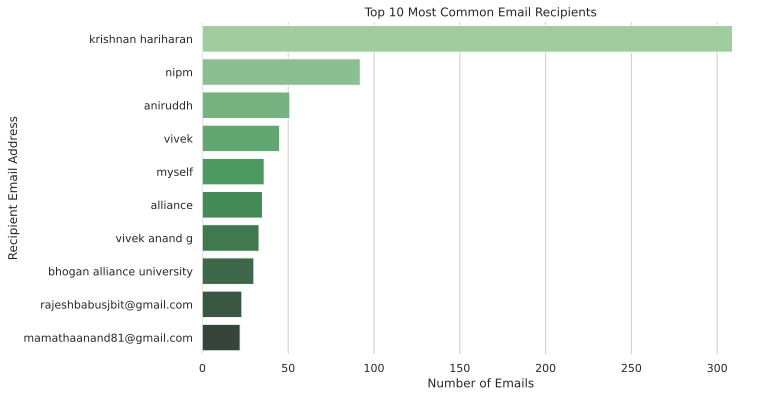

In [ ]:
df_top10 = df['to'].value_counts()[1:11].reset_index()
df_top10.columns = ['to', 'count']

sns.set_style("whitegrid")
sns.set_color_codes("pastel")
plt.figure(figsize=(10, 6))
sns.barplot(x='count', y='to', data=df_top10, palette='Greens_d')
plt.title('Top 10 Most Common Email Recipients')
plt.xlabel('Number of Emails')
plt.ylabel('Recipient Email Address')

sns.despine(left=True, bottom=True)
plt.show()


:Now we can check from whom i received most number of emails. But the problem with the from email is duplicate email IDs. *`Eg - no-reply@ncp.flipkart.com and no-reply@ncb.flipkart.com`* they both are same but if we count the number of
emails both the email IDs will show seperate counts. So for this we can create
nicknames just the way we created for sent mails.

In [ ]:
df['from'] = df['from'].apply(lambda x: nickname(x, ['hdfc'], 'hdfc'))
df['from'] = df['from'].apply(lambda x: nickname(x, ['linkedin'], 'linkedin'))
df['from'] = df['from'].apply(lambda x: nickname(x, ['angel'], 'angel'))
df['from'] = df['from'].apply(lambda x: nickname(x, ['indeed'], 'indeed'))
df['from'] = df['from'].apply(lambda x: nickname(x, ['phonepe'], 'phonepe'))
df['from'] = df['from'].apply(lambda x: nickname(x, ['instagram'], 'instagram'))
df['from'] = df['from'].apply(lambda x: nickname(x, ['myntra'], 'myntra'))
df['from'] = df['from'].apply(lambda x: nickname(x, ['flipkart'], 'flipkart'))
df['from'] = df['from'].apply(lambda x: nickname(x, ['quora'], 'quora'))
df['from'] = df['from'].apply(lambda x: nickname(x, ['kotak'], 'kotak'))
df['from'] = df['from'].apply(lambda x: nickname(x, ['citi'], 'citi bank'))

In [ ]:
df['from'].value_counts()[1:8]

hdfc                                                                                       317
nipm kc <nipmkc@gmail.com>                                                                  94
james clear <james@jamesclear.com>                                                          82
"operations, school of business, alliance university"\r\n\t<operations@alliance.edu.in>     74
vivekanand <vivekanand.g@alliance.edu.in>                                                   67
aniruddhkrishnan9995@outlook.com                                                            66
harvard business publishing education <hbpmarketing@hbsp.harvard.edu>                       55
Name: from, dtype: int64

This shows the count of emails which were received. All these results can be visualized

<ipython-input-74-abcb50298524>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_top7, y=df_top7.index, palette='Blues_d')
) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


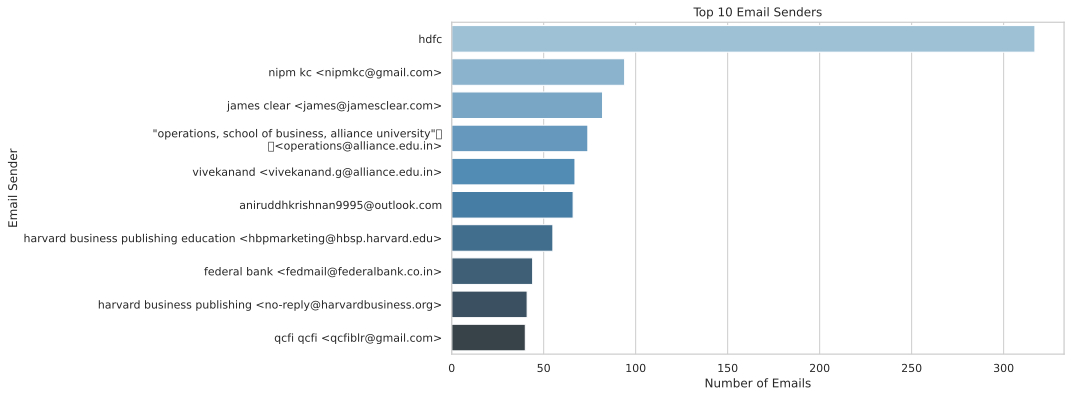

In [ ]:
df_top7 = df['from'].value_counts()[1:11]
sns.set_style('whitegrid')
plt.figure(figsize=(11,6))
sns.barplot(x=df_top7, y=df_top7.index, palette='Blues_d')
plt.xlabel('Number of Emails')
plt.ylabel('Email Sender')
plt.title('Top 10 Email Senders')
plt.show()

### 4. Most common topics
The content of the messages is unavailable; however, the subject of each message can clearly indicate the recurrent topics for both incoming and outgoing emails. which can be visualized in word cloud.

In [ ]:
all_wrds_in = []
for wrds in list(df['subject'][df['to'] == 'me']):
    all_wrds_in.extend(str(wrds).lower().split())

all_wrds_out = []
for wrds in list(df['subject'][df['from'] == 'me']):
    all_wrds_out.extend(str(wrds).lower().split())

In [ ]:
all_wrds_in[:6]

["=?utf-8?q?krishnan,_it_can't_get_better_than_this._lifetime_free_credit_?=",
 '=?utf-8?q?=f0=9f=92=b3?=',
 're:',
 'article',
 'to',
 'be']

In [ ]:
my_stopwords = ['re:', 'nan', 'none', '-', 'fwd:', 'fw:',
                '&', 'hola', 'saludos', 'order', 'amazon.com']

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from nltk.corpus import stopwords
stopwords_en = set(stopwords.words('english'))
all_stopwords = stopwords_en | set(my_stopwords)

In [ ]:
len(all_wrds_in), len(all_wrds_out)

(9437, 2450)

In [ ]:
all_wrds_in = [wrd for wrd in all_wrds_in if wrd not in all_stopwords]
all_wrds_out = [wrd for wrd in all_wrds_out if wrd not in all_stopwords]

In [ ]:
len(all_wrds_in), len(all_wrds_out)

(6636, 1575)

In [ ]:
wrds_in = Counter(all_wrds_in)
wrds_out = Counter(all_wrds_out)

In [ ]:
wrds_in.most_common(10)

[('account', 190),
 ('bank', 177),
 ('hdfc', 164),
 ('update', 154),
 ('a/c', 147),
 ('view:', 143),
 ('3-2-1:', 71),
 ('learning', 66),
 ('project', 65),
 ('computer', 61)]

In [ ]:
wrds_out.most_common(10)

[(':', 54),
 ('faculty', 40),
 ('application', 35),
 ('project', 33),
 ('paper', 30),
 ('epgdm', 25),
 ('learning', 24),
 ('request', 22),
 ('management', 19),
 ('4', 17)]

In [ ]:
from wordcloud import WordCloud, STOPWORDS

In [ ]:
words_in = ''
for t in wrds_in.most_common(150):
    for i in range(t[1]):
        words_in += t[0] + ' '

words_out = ''
for t in wrds_out.most_common(150):
    for i in range(t[1]):
        words_out += t[0] + ' '

# **Word cloud of incoming mails**

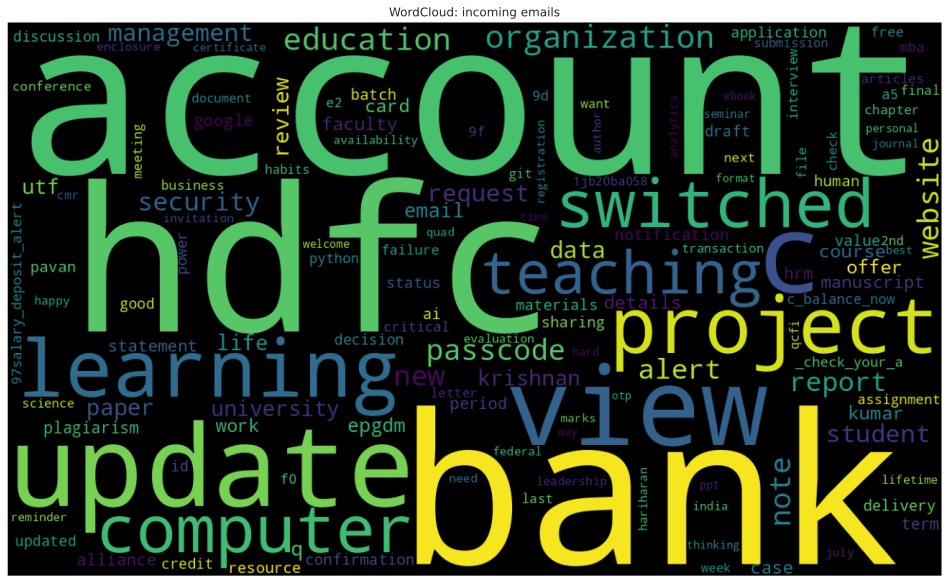

In [ ]:
wordcloud_in = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=1350, height=800,
                      collocations=False
                     ).generate(words_in)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud_in)
plt.axis('off')
plt.title('WordCloud: incoming emails');

# **Word cloud of outgoing mails**

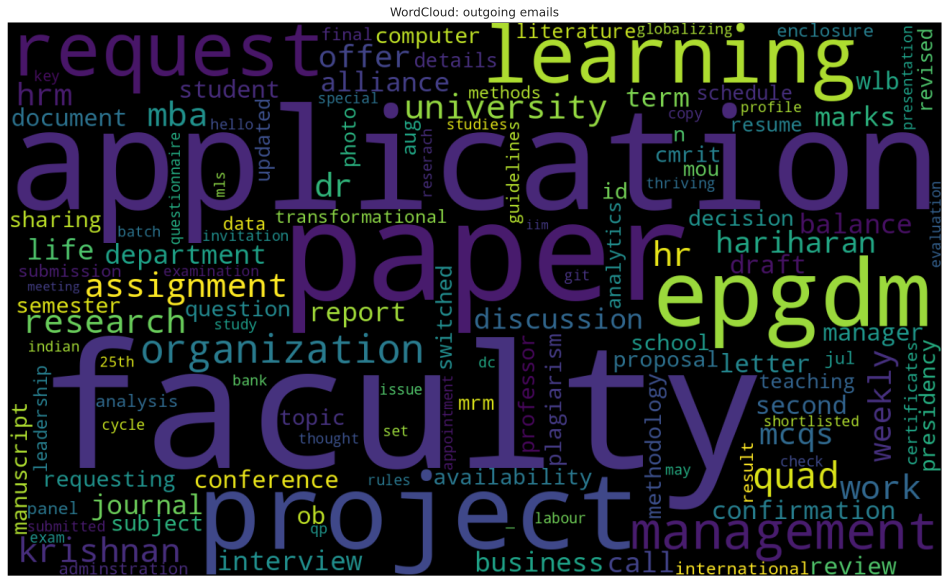

In [ ]:
wordcloud_out = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=1350, height=800,
                      collocations=False
                     ).generate(words_out)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud_out)
plt.axis('off')
plt.title('WordCloud: outgoing emails');